In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\hp\Downloads\train(1)(train(1)).csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [4]:
df.drop(['id' , 'date'] , axis = 1 , inplace = True)

In [5]:
import os

IMAGE_DIR = "images/satellite"
os.makedirs(IMAGE_DIR, exist_ok=True)

print("Image directory ready:", IMAGE_DIR)

Image directory ready: images/satellite


In [6]:
from data_fetch import fetch_satellite_image

In [7]:
import time

for idx, row in df.head(6000).iterrows():
    path = f"images/satellite/{idx}.png"
    if not os.path.exists(path):
        fetch_satellite_image(row["lat"], row["long"], path)
        time.sleep(0.2)

In [8]:
df["image_path"] = df.index.map(lambda idx: f"images/satellite/{idx}.png")
df_img = df[df["image_path"].apply(os.path.exists)].copy()
df_img['price'] = df['price'][:df_img['image_path'].size]

In [9]:
df_img['price'].size

6024

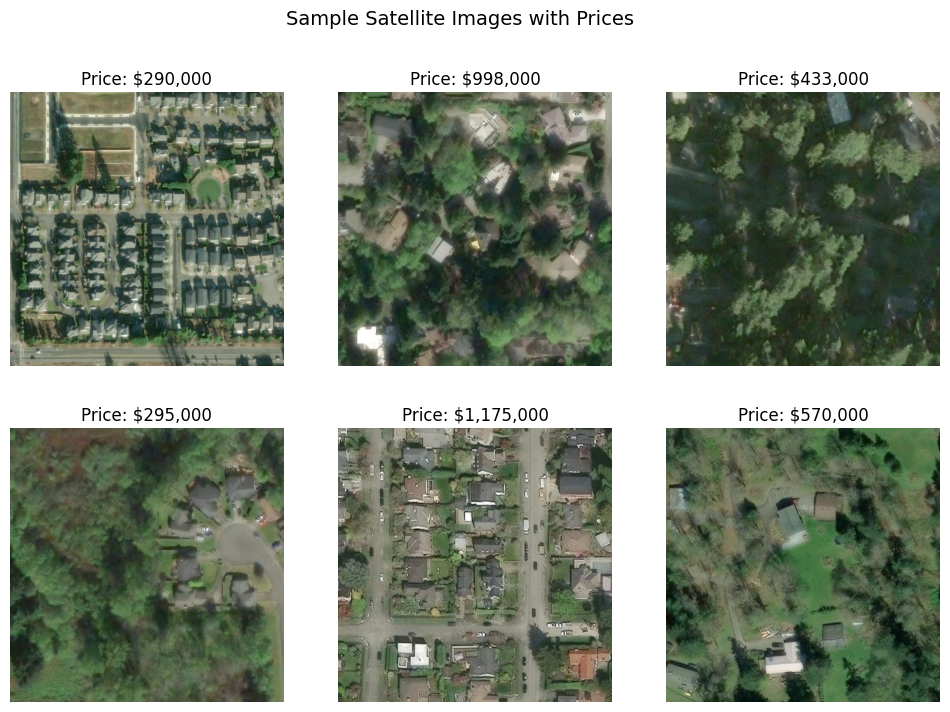

In [10]:
from PIL import Image
import random

sample_indices = random.sample(list(df_img.index), 6)

plt.figure(figsize=(12,8))

for i, idx in enumerate(sample_indices):
    img = Image.open(df_img.loc[idx, "image_path"])
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Price: ${df_img.loc[idx, 'price']:,}")
    plt.axis("off")

plt.suptitle("Sample Satellite Images with Prices", fontsize=14)
plt.show()

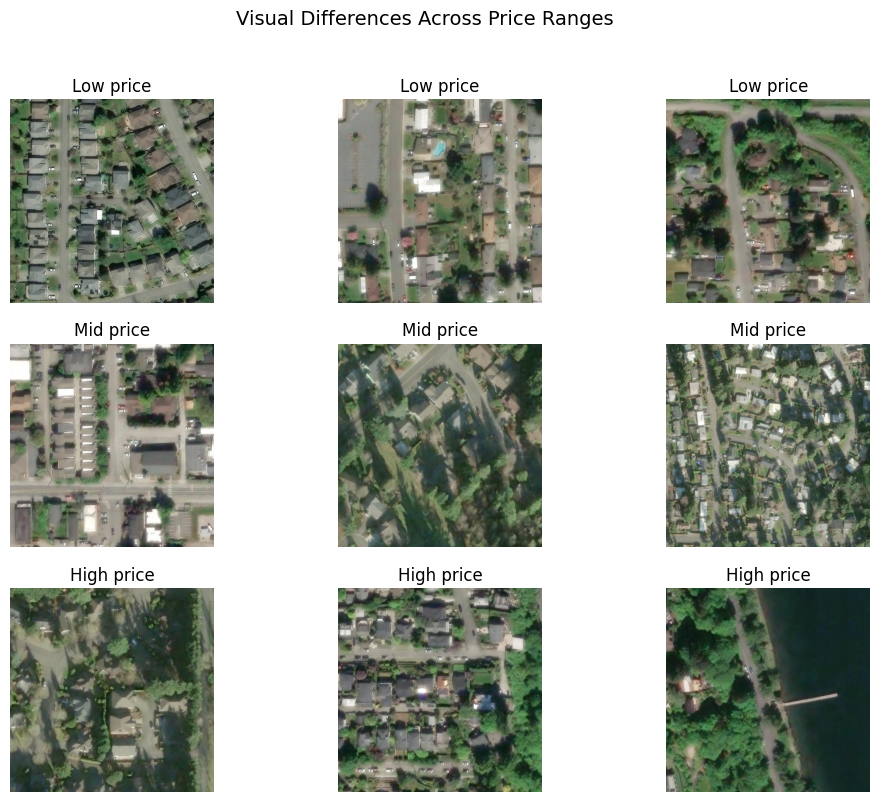

In [11]:
df_img["price_bin"] = pd.qcut(df_img["price"], q=3, labels=["Low", "Mid", "High"])
plt.figure(figsize=(12,9))

for i, label in enumerate(["Low", "Mid", "High"]):
    subset = df_img[df_img["price_bin"] == label].sample(3, random_state=42)

    for j, (_, row) in enumerate(subset.iterrows()):
        img = Image.open(row["image_path"])
        plt.subplot(3, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"{label} price")
        plt.axis("off")

plt.suptitle("Visual Differences Across Price Ranges", fontsize=14)
plt.show()

In [12]:
def ratio(img , clr):
    img = np.array(img)
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    if clr == 'green':
        return ((g > r) & (g > b)).mean()
    if clr == 'blue' :
        return ((b > r) & (g < b)).mean()

In [13]:
df_vis = df_img.sample(500, random_state=42).copy()

df_vis["green_ratio"] = df_vis["image_path"].apply(
    lambda p: ratio(Image.open(p) , 'green')
)

df_vis["blue_ratio"] = df_vis["image_path"].apply(
    lambda p: ratio(Image.open(p) , 'blue')
)

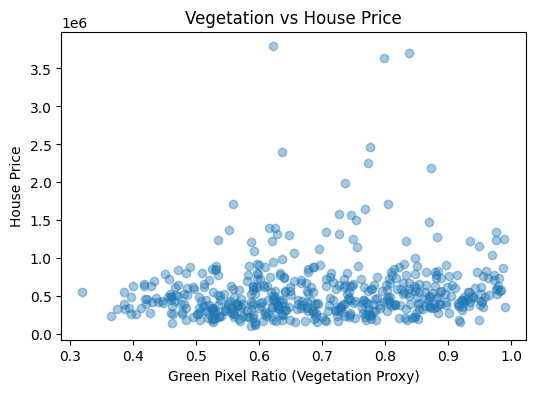

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(df_vis["green_ratio"], df_vis["price"], alpha=0.4)
plt.xlabel("Green Pixel Ratio (Vegetation Proxy)")
plt.ylabel("House Price")
plt.title("Vegetation vs House Price")
plt.show()
#only vegetation is not a direct indicator of house prices , other factors like habitation around is also important

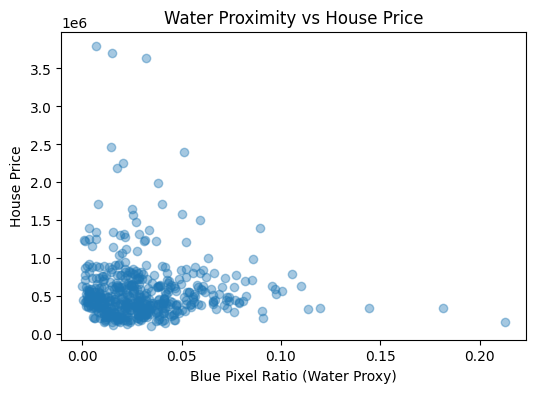

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(df_vis["blue_ratio"], df_vis["price"], alpha=0.4)
plt.xlabel("Blue Pixel Ratio (Water Proxy)")
plt.ylabel("House Price")
plt.title("Water Proximity vs House Price")
plt.show()
#this proxy is incorrct because 
#1. Most houses are NOT near water
#2. Blue ≠ water
#3. Scale mismatch

In [16]:
import cv2

def edge_density(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges.mean()


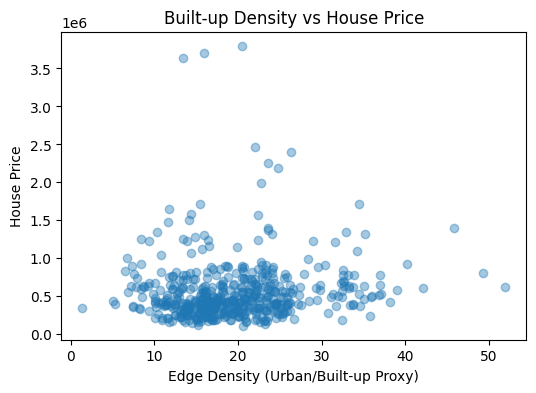

In [17]:
df_vis["edge_density"] = df_vis["image_path"].apply(
    lambda p: edge_density(Image.open(p))
)
plt.figure(figsize=(6,4))
plt.scatter(df_vis["edge_density"], df_vis["price"], alpha=0.4)
plt.xlabel("Edge Density (Urban/Built-up Proxy)")
plt.ylabel("House Price")
plt.title("Built-up Density vs House Price")
plt.show()
